# Path Signature Methodology for Landmark-based Human Action Recognition

This notebook is based on the paper
> Weixin Yang, Terry Lyons, Hao Ni, Cordelia Schmid, Lianwen Jin, "Developing the Path Signature Methodology and its Application to Landmark-based Human Action Recognition", arXiv preprint arXiv:1707.03993v2, 2019

which is available as an arXiv __[preprint](https://arxiv.org/ftp/arxiv/papers/1707/1707.03993.pdf)__. 

Human action recognition is a challenging task in computer vision with many potential applications, ranging from human-computer interaction and video understanding to video surveillance, behavioural analysis and many more. In this task we are given a short video clip showing one person (or possibly several) performing exactly one action and the task is to output the action that was performed in the video.

In this notebook we give an introduction to the methodology developed in above paper. We begin with explaining the landmark-based approach and why it is a desirable approach. We then show how to generate a feature set based on above paper and train a simple classifier on the __[Joint-annotated Human Motion Data Base (JHMDB)](http://jhmdb.is.tue.mpg.de/)__ dataset.

We begin by setting up the coding environment.

## Set up the Notebook
### Install Dependencies
There are two steps for installing the dependencies for this notebook:

In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt

  Cloning git://github.com/kschlegel/PSFDataset.git (to revision fc616da584aec841f2497bd03139318841d9ea73) to c:\users\wyang\appdata\local\temp\pip-req-build-bdfnj32g
  Cloning git://github.com/kschlegel/DatasetLoader.git (to revision 88587de554bf377874655e29aa1397d9ff348f49) to c:\users\wyang\appdata\local\temp\pip-req-build-1enkrteh
  Using cached notebook-6.1.1-py3-none-any.whl (9.4 MB)
  Using cached opencv_python-4.2.0.34-cp36-cp36m-win_amd64.whl (33.0 MB)
  Using cached scikit_learn-0.23.1-cp36-cp36m-win_amd64.whl (6.8 MB)
  Using cached matplotlib-3.2.1-cp36-cp36m-win_amd64.whl (9.2 MB)
  Using cached requests-2.22.0-py2.py3-none-any.whl (57 kB)
  Using cached tqdm-4.46.1-py2.py3-none-any.whl (63 kB)
  Using cached argon2_cffi-20.1.0-cp36-cp36m-win_amd64.whl (42 kB)
  Using cached jupyter_client-6.1.12-py3-none-any.whl (112 kB)
  Attempting uninstall: pywinpty
    Found existing installation: pywinpty 0.5.5
    Uninstalling pywinpty-0.5.5:
      Successfully uninstalled pywinpty

For the learning we are going to use __[PyTorch](https://pytorch.org/)__. The correct version of PyTorch to install depends on your hardware, operating system and CUDA version, thus __it is recommended to install PyTorch manually__, following the [official instructions](https://pytorch.org/get-started/locally/).<br>
This notebook was developped and tested using PyTorch version 1.5.0, instructions for installing this version can be found [here](https://pytorch.org/get-started/previous-versions/#v150).<br>
If you don't want to install PyTorch manually you can try uncommenting the second line in the following cell and run it and the notebook will attempt to install PyTorch v1.5.0 for you, we cannot guarantee you will end up with the right version to match your system though.

In [ ]:
# Uncomment the following line to try to install torch via the extra requirements file (not recommended):
# !{sys.executable} -m pip install -r requirements_torch.txt

### Import Packages

In [1]:
import os.path
import sys
import zipfile

from tqdm.notebook import tqdm, trange
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import torch

from psfdataset import PSFDataset, transforms

import pickle
from sklearn.model_selection import StratifiedKFold
from joblib import Parallel, delayed
from preprocess import pre_normalization, get_data_duration

import time
#from importlib import reload

Ignoring attempt to add_dll_directory.


## Download and Load the Dataset

In [2]:
# load data

def load_uav_data(dir_name, flag = 'train'):
    data_uav = np.load(os.path.join(dir_name,'{}_process_data.npy'.format(flag)))#mmap_mode = None, 'r‘
    N,C,T,V,M = data_uav.shape
    #print(N,C,T,V,M)

    with open(os.path.join(dir_name,'{}_process_label.pkl'.format(flag)), 'rb') as f:
        sample_name, label_uav = pickle.load(f)
    
    label_uav = np.array(label_uav)

    length_uav = np.load(os.path.join(dir_name,'{}_process_length.npy'.format(flag)))
    #print(label_uav.shape)
    return data_uav,label_uav,length_uav

DATASET_PATH = "C:\\Users\\wyang\\PycharmProjects\\data\\skeleton_action_recognition_train_split"
#"./data/skeleton_action_recognition_train_split"

data_uav,label_uav,length_uav = load_uav_data(DATASET_PATH,'train')
data_uav = data_uav[:,:2] # all the z values are zeros
print(data_uav.shape,label_uav.shape,length_uav.shape)

(16718, 2, 305, 17, 2) (16718,) (16718,)


In [3]:
data_dist = np.transpose(data_uav,(1,4,3,0,2))[...,:305]
print(data_dist.shape)
data_dist = data_dist.reshape(*data_dist.shape[:1],-1)
print(data_dist.shape)
print(np.fabs(data_dist).mean(-1))
'''
fig = plt.figure()

for i in range(3):
    ax = fig.add_subplot(3,1,i+1)
    ax.boxplot(data_dist[i,::100000])

plt.show()
'''


(2, 2, 17, 16718, 305)
(2, 173365660)
[0.1257653 0.1612133]


'\nfig = plt.figure()\n\nfor i in range(3):\n    ax = fig.add_subplot(3,1,i+1)\n    ax.boxplot(data_dist[i,::100000])\n\nplt.show()\n'

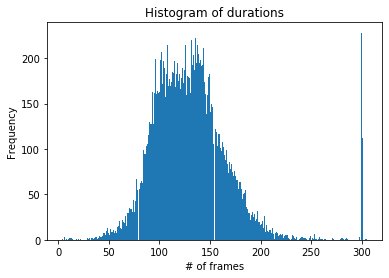

In [4]:
plt.hist(length_uav, bins = length_uav.max())
plt.ylabel('Frequency')
plt.xlabel('# of frames')
plt.title('Histogram of durations')
plt.show()

In [5]:
class_num = 155
cross_val_fold_num = 5

print('Check data imbalance...')
class_cnt = np.zeros(class_num)
for l in label_uav:
    class_cnt[l] += 1
print(class_cnt)
print('Avg sample num: ',class_cnt.mean())
print('Max sample num: ',class_cnt.max())
print('Min sample num: ',class_cnt.min())

k_fold = StratifiedKFold(cross_val_fold_num)
k_fold.get_n_splits(data_uav,label_uav)
k_fold_idx_dict = dict()

print('Create {}-fold for cross validation...'.format(cross_val_fold_num))
for k, (train, val) in enumerate(k_fold.split(data_uav,label_uav)):
    k_fold_idx_dict.update({str(k):{'train':train, 'val':val}})
    print(k+1,'- fold:','Trainset size: ',len(train),' Valset size: ',len(val))


Check data imbalance...
[127. 127. 127. 126. 124. 126. 126. 126. 127. 125. 126. 125. 124. 124.
 123. 125. 124. 127. 125. 125. 124. 124. 124. 125. 126. 125. 126. 124.
 124. 126. 123. 125. 124. 126. 122. 123. 121. 121. 123. 121. 122. 123.
 123. 120. 120. 120. 122. 122. 122. 120. 120. 120. 120. 119. 121. 121.
 122. 118. 119. 120. 119. 119. 122. 122. 122. 120. 121. 120. 119. 118.
 118. 118. 119. 119.  94.  94.  93.  94.  93.  94.  93.  93.  93.  93.
  92.  93.  92.  93.  93.  92.  93.  93.  93.  93.  93.  93.  93.  93.
  90. 110. 109. 109. 108. 107. 108. 107. 107. 107. 107. 104. 106. 106.
 106. 106. 106. 106. 105. 105. 105. 105. 105. 101. 108.  87. 101. 109.
 110. 106.  86. 122.  92.  85.  85.  87.  85.  85.  97.  97.  98.  99.
  97.  98.  98. 100.  98.  97.  86.  20.  86.  98. 102.  95.  20.  20.
  20.]
Avg sample num:  107.85806451612903
Max sample num:  127.0
Min sample num:  20.0
Create 5-fold for cross validation...
1 - fold: Trainset size:  13374  Valset size:  3344
2 - fold: Trainse

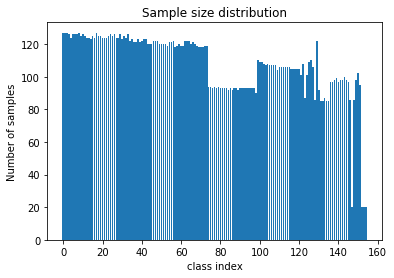

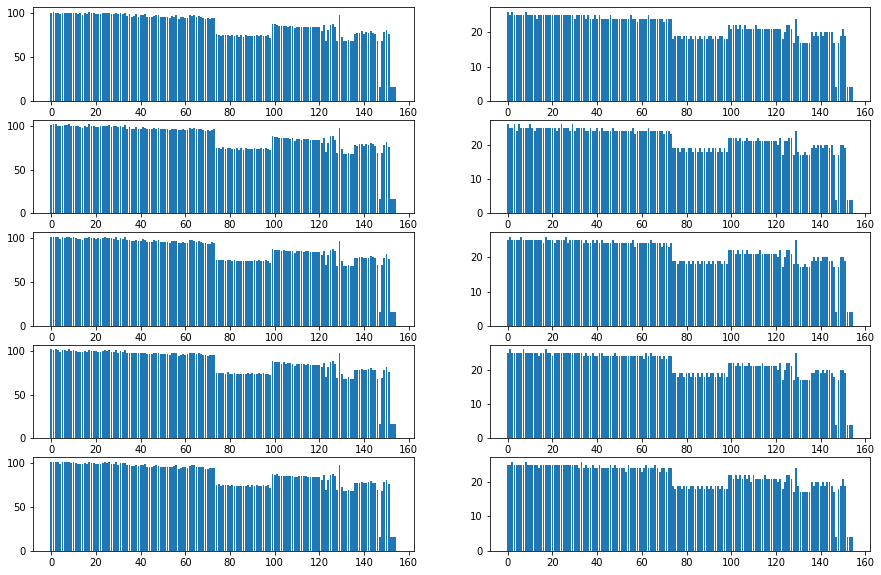

In [6]:
plt.bar(np.arange(class_num),class_cnt)
plt.title('Sample size distribution')
plt.xlabel('class index')
plt.ylabel('Number of samples')
plt.show()

fig = plt.figure(figsize = (15,10))
for i_fold in range(cross_val_fold_num): 
    train_index = k_fold_idx_dict[str(i_fold)]['train']
    val_index = k_fold_idx_dict[str(i_fold)]['val']
    label_train = label_uav[train_index]
    label_val = label_uav[val_index]

    class_cnt = np.zeros(class_num)
    for l in label_train:
        class_cnt[l] += 1
    ax1 = fig.add_subplot(cross_val_fold_num,2,i_fold*2+1)
    ax1.bar(np.arange(class_num),class_cnt)

    class_cnt = np.zeros(class_num)
    for l in label_val:
        class_cnt[l] += 1
    ax2 = fig.add_subplot(cross_val_fold_num,2,i_fold*2+1+1)
    ax2.bar(np.arange(class_num),class_cnt)

plt.show()
    



## Path Signature Methodology
You can see that in this dataset each person is represented by 15 landmarks in 2D. Thus the skeleton in an individual frame can be considered a point in $\mathbb{R}^{15}\times\mathbb{R}^2\simeq\mathbb{R}^{30}$. We can then view a sequence of skeletons $x=(x_0,...,x_N)\subset\mathbb{R}^{30}$ from a video clip with $N+1$ frames as a discretisation of an underlying continuous path $P:[0,1]\rightarrow\mathbb{R}^{30}$, where each frames skeleton $x_i$ is a sample of the human motion at a time $t=\frac{i}{N}\in[0,1]$. Classifying the action now means making sense of this path.

### The Path Signature
The path signature is one of the central objects of the mathematical field of rough path theory. It is a powerful tool to efficiently and concisely describe a path like the continuous path $P:[0,1]\rightarrow\mathbb{R}^{30}$ above. The path signature describes the path independently of its time parametrisation but preserves the order in which things happen. Thus it is invariant to e.g. the sampling rate, a desirable property since a human action itself is invariant to the frame rate of the video recording or the speed at which the action was performed. Moreover, the signature is robust with respect to missing frames.

The signature is defined as repeated integrals of the path $P$. If we denote the $d$ components of the path $P$ at time $t$ by $(X^1_t,\ldots,X^d_t)$ (in our case $d=30$) then the first order integrals of the path $P$ are given by 
$${S(P)}^{i}=\int\limits_{0<s<1} d X_{s}^{i}=X_{1}^{i}-X_{0}^{i}$$
for every $i\in\{1,\ldots,d\}$. Similarly the second order integrals are given by 
$${S(P)}^{i, j}=\iint\limits_{0<t_1<t_2<1} d X_{t_1}^{i} d X_{t_2}^{j}$$
for every $i,j\in\{1,\ldots,d\}$. Repeating this process, for any integer $k\geq1$ the repeated integral of order $k$ is given by
$${S(P)}^{i_{1}, \ldots, i_{k}}=\idotsint\limits_{0<t_{1}<\cdots<t_{k}<1} d X_{t_{1}}^{i_{1}} \ldots d X_{t_{k}}^{i_{k}}$$
for every collection of indices $i_1,\ldots,i_k\in\{1,\ldots,d\}$. The signature of the path $P$ is now given by the infinite sequence of all such repeated integrals
$${S(P)}=\left(1, {S(P)}^{1}, \ldots, {S(P)}^{d}, {S(P)}^{1,1}, {S(P)}^{1,2}, \ldots\right)$$
The number of integrations $k\in\mathbb{N}$ over the path $P$ is commonly referred to as the level of the signature. Each of the $k$ integrations is along one coordinate axis. The index set $i_1,\ldots,i_k$ describes the set of coordinate axes and the order in which we perform these $k$ integrations. For a path in $d$ dimensions we have $d^k$ possible choices for this index set $i_1,\ldots,i_k$ of integrations. This means the number of terms in the sequence $Sig(x)$ grows exponentially with the level $k$.

Since the full signature is an infinite sequence of repeated integrals in practice we have to choose a finite truncation by computing the integrals only up to a finite level $N$, i.e. $0\leq k\leq N$ in above equation. This is referred to as the Signature of level $N$, denoted by $Sig^N(x)$. Since the number of integrals grows exponentially with each extra level commonly only few (less than 10) levels of the signature are computed.

In practice, to compute the signature from a skeleton sequence $x=(x_0,...,x_N)\subset\mathbb{R}^{30}$ we assume the path $P$ to be the piecewise linear interpolation of the skeleton sequence, i.e. $P(\frac{i}{N})=x_i$ for each $i\in\{0,\ldots,N\}$, and linear in between the sample points.

Some more detail on the path signature can be found in our main reference, the paper by Yang et al., or in one of the following references:

* I. Chevyrev and A. Kormilitzin, "A Primer on the Signature Method in Machine Learning", arXiv preprint arXiv:1603.03788, 2016, https://arxiv.org/pdf/1603.03788.pdf

* T. Lyons, "Rough paths, Signatures and the modelling of functions on streams", In <i>Proceedings of the International Congress of Mathematicians: Seoul</i>, pp. 163‐184, 2014, (available on arXiv: https://arxiv.org/pdf/1405.4537.pdf)

* T. Lyons, M. J. Caruana and T. Lévy, "Differential Equations Driven by Rough Paths: Ecole d’Eté de Probabilités de Saint-Flour XXXIV-2004", <i>Lecture Notes in Mathematics École d'Été de Probabilités de Saint-Flour</i>, Springer 2007, DOI https://doi.org/10.1007/978-3-540-71285-5

### Path Transformations
The full signature $Sig(x)$ determines the path essentially uniquely, but we only consider a finite truncation $Sig^N(x)$. The k-th term of the signature is of size $\mathcal{O}(\frac{1}{k!})$ so often this may not be an issue as the first $N$ levels of the signature contain the largest terms. But if the function we try to learn strongly depends on higher order terms of the signature then important information has been lost.
In order tackle this problem a number of path transformations have been introduced which help to capture various important properties of a path in lower order terms of the signature. A description of the variety of the path transformations and their effects can be found in the above mentioned paper. We are going to describe the selection of path transformations we are using in this notebook and illustrate them with easy examples.

0. **Crop & Normalize**

    These are not path signature specific path transformations. As it is common in machine learning we crop and normalize the landmark coordinates to be within the interval $[-1,1]$ by cropping to the landmark bounding box, extending the shorter side symmetrically to a square box and then scaling the box down to the target interval.


1. **Spatio-Temporal Path**

    There are two kinds of path transformations, spatial and temporal transformations, which assume a different structure of the path.
    
    Transformations such as the crop and normalise above are spatial transformations, operating on the spatial coordinates at each individual time step not on a time series. Similarly it is possible to view a set of $n$ landmarks as $n$ samples of a path in $\mathbb{R}^2$ and then take the signature of each of those spatial paths of length $n$. As an example, you could take all possible pairs of landmarks within one frames and consider each pair a path with 2 sample points. Thus spatial transformations expect a sequence of the form `[frame][landmark][coordinates]` to loop over the frames and process the spatial coordinates.
    
    Temporal transformations on the other hand operate on all or a subset of the spatial coordinates across time, some examples are presented below. For this reason they expect a sequence of the form `[element][frame][coordinates]` which is referred to as a spatio-temporal path. Thus after applying all spatial transformations we want to use we need to transform from a spatial path into a spatio-temporal path before proceeding with temporal transformations.
    
    
2. **Multi-delayed transformation**

    To better encode temporal dependencies one can use the multi-delayed transformation of the  path. For this the path is augmented with several delayed versions of itself so that at any point of the path the information of several timesteps is available. The individual copies of the path are zero-padded as required.
    
    As an example, the path $[[2,3],[4,6],[8,9]]$ with a delay of 1 turns into $[[[2,3],[0,0]],[[4,6],[2,3]],[[8,9],[4,6]],[[0,0],[8,9]]]$. (Note our implementation adds another dimension and outputs in a path in $\mathbb{R}^{d+1}\times\mathbb{R}^n$ where $d$ is the delay and $n$ is the dimension of the original path.
    
    
3. **Temporal disintegration into dyadic path signatures**

    For long paths it can often be more efficient (comparable performance on a smaller feature set) to consider lower level terms of signatures on intermediate time intervals rather than higher order terms of the signature of the full path. An efficient way of doing this is to take signatures of a dyadic hierarchical structure. At each dyadic level we split the intervals of the previous level in half, i.e. level 0 contains the whole path, level 1 its two halves, level 2 the four quarters etc., as can be seen on the left in the diagram below. To avoid breaking events occurring near the splits into subintervals we can consider overlapping dyadic intervals, i.e. three halfs $[0,T/2]$, $[T/4,3T/4]$ and $[T/2,T]$ on level 1, 7 quarters $[0,T/4],[T/8,3T/8],...,[3T/4,T]$ etc., as can be seen on the right in the diagram below.
    
    ![Visualisation of (overlapping) dyadic intervals](dyadic_intervals.png)
    
    To illustrate this point in our reference paper Yang et al. state that they observed better performance for taking signatures of level 2 over a overlapping dyadic hierarchy up to level 2 (i.e. the whole interval, halves and quarters) than taking signatures of level 5 of the whole time interval. Since the size of the truncated signature grows exponentially with the level, taking signatures of 1 full + 3 half + 7 quarter = 11 pieces of level 2 results in a considerably smaller feature set than a level 5 signature of the whole sequence.

In [7]:
tr = transforms.Compose([
    #transforms.spatial.Crop(),
    #transforms.spatial.Normalize(),
    #transforms.spatial.Tuples(2),
    transforms.SpatioTemporalPath(),
    transforms.temporal.MultiDelayedTransformation(2),
    transforms.temporal.DyadicPathSignatures(dyadic_levels=2,
                                             signature_level=4, overlapping = True)
])

tr_emp = transforms.Compose([transforms.spatial.Normalize()])

### Generate the Path Signature Feature Set

In [8]:
def get_iter(data,label,length): 
    """
    Returns iterators over the requested
    subset of the data.
    """
    it = []
    for d,lab,l in zip(data, label, length):
        it += [(d[:l],lab)]
        
    return iter(it)

def get_fea_iter(fea,label):
    it = []
    for f,lab in zip(fea, label):
        it += [(f,lab)]
        
    return iter(it)

def featureNormalize(feaset, valfeaset):
    feaset = np.stack(feaset)
    valfeaset = np.stack(valfeaset)
    shape = feaset.shape
    feaset = feaset.reshape(shape[0],-1)
    norm_factors = np.fabs(feaset).max(0,keepdims = True)
    zero_factors = (norm_factors == 0)
    if zero_factors.sum().item() > 0:  print('Zero Norm Factor warning: ', zero_factors.sum(), np.where(zero_factors))
    else: print('Feature norm factor checked')
    norm_factors += np.array(zero_factors, dtype = np.float32)
    norm_factors = 1.0 / norm_factors
    print(np.fabs(norm_factors).sum())
    norm_factors = norm_factors.reshape(1,-1)
    feaset = feaset * norm_factors
    feaset = feaset.reshape(shape)

    val_shape = valfeaset.shape
    valfeaset = (valfeaset.reshape(val_shape[0],-1) * norm_factors).reshape(val_shape)
    return feaset, valfeaset, norm_factors

    


In [9]:
isFastTestSubset = True
isLoadFeature = 1
isFeaExtractParallel = 1
isSaveFeature = 1

data = np.transpose(data_uav,(0,2,4,3,1))
if isFastTestSubset:
    data = data[:,:,0,...]
else:
    data = data.reshape(*data.shape[:2], -1, *data.shape[4:])
print(data.shape)

fold_idx = 0
if isFastTestSubset:
    step = 1
    train_index = k_fold_idx_dict[str(fold_idx)]['train'][::step]
    val_index = k_fold_idx_dict[str(fold_idx)]['val'][::step]
else:
    trsain_index = k_fold_idx_dict[str(fold_idx)]['train']
    val_index = k_fold_idx_dict[str(fold_idx)]['val']

train_data = data[train_index]
print(train_data.shape)
train_label = label_uav[train_index]
train_length = length_uav[train_index]

val_data = data[val_index]
print(val_data.shape)
val_label = label_uav[val_index]
val_length = length_uav[val_index]


trainingset = PSFDataset(transform=tr)
valset = PSFDataset(transform=tr)


if isLoadFeature:
    trainingset.load("uav_train")
    trainingset._data = trainingset._data[::2]
    trainingset._labels = trainingset._labels[::2]
    valset.load("uav_test")
else:
    oneSampleSet = PSFDataset(transform=tr)
    oneSampleSet.fill_from_iterator(get_iter(train_data[0:1],train_label[0:1],lengths[0:1]))
    print("Dimension of feature vector:", oneSampleSet.get_data_dimension())

    if isFeaExtractParallel:
        trainingset._data = Parallel(n_jobs=-1)(delayed(trainingset._transform)(sample) for sample in tqdm(train_data))
        trainingset._labels = train_label.tolist()
        valset._data = Parallel(n_jobs=-1)(delayed(valset._transform)(sample) for sample in tqdm(val_data))
        valset._labels = val_label.tolist()

    else:
        trainingset.fill_from_iterator(get_iter(train_data, train_label, length_uav))
        valset.fill_from_iterator(get_iter(val_data, val_label, length_uav))
    
    if isSaveFeature:
        trainingset.save("uav_train")
        valset.save("uav_test")

trainingset._data, valset._data, norm_factors = featureNormalize(trainingset._data, valset._data)

print("Number of trainingset elements:", len(trainingset))
print("Number of testset elements", len(valset))
print("Dimension of feature vector:", trainingset.get_data_dimension())


(16718, 305, 17, 2)
(13374, 305, 17, 2)
(3344, 305, 17, 2)
Zero Norm Factor warning:  136 (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=int64), array([    2,     8,    26,    80,  1333,  1339,  1357,  1411,  2664,
        2670,  2688,  2742,  3995,  4001,  4019,  4073,  5326,  5332,
        5350,  5404,  6657,  6663,  6681,  6735,  7988,  7994,  8012,
        8066,  9319,  9325,  9343,  9397, 10650, 10656, 10674, 10728,
       11981, 11987, 12005, 12059, 13312, 13318, 13336, 13390, 14643,
       14649, 14667, 14721, 15974, 15980, 15998, 16052, 17305, 17311,
       17329, 173

## Learn an action classifier

### Setup PyTorch
Set random seed:

In [10]:
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

Train on GPU if available:

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print("Device:", device)

Device: cuda:0


### Define the Learning Framework
#### The Signature is a Universal Approximator - Learn a Linear Model
The aim of the path signature methodology is not to replace deep learning or any other machine learning techniques but to complement them. The signature can be thought of as a <b>"universal nonlinearity"</b>, every continuous function of a
path may be approximated arbitrarily well by a linear function of its signature. This is clearly a very desirable property, mathematical details and proofs can be found in the papers referenced in the section introducing the path signature.

The universality of the signature and the various path transformations allow us to learn a simple _linear function_ on top of our path signature feature set to do the classification and achieve strong results. For research exploring using the path signature transform in combination with deep learning consider e.g. the following papers and the references therein:
* P. Kidger, P. Bonnier, I. Perez Arribas, C. Salvi and T. Lyons, "Deep Signature Transforms", In <i>Advances in Neural Information Processing Systems 32</i>, pp. 3105-3115, 2019, http://papers.nips.cc/paper/8574-deep-signature-transforms.pdf
* S. Liao, T. Lyons, W. Yang and H. Ni, "Learning stochastic differential equations using RNN with log signature features",  arXiv preprint arXiv:1908.08286, 2019, https://arxiv.org/abs/1908.08286

In this notebook we are not using any deep learning, but learn a <i>linear classifier</i>. This has the advantages that it is easy to train and leads to an interpretable classifier. To determine which features are most important for the classifiers decision we only need to find the largest activations of the linear map. The paper cited above does this for their final, most complex feature set and identifies which combinations of joints, and which time intervals are most relevant for the classifiers decisions.

In [16]:
class LinearClassifierNet(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        torch.nn.Module.__init__(self)
        self.linear = torch.nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        x = self.linear(x)
        return x

class LinearClassifierNet_2layer(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        torch.nn.Module.__init__(self)
        intermedia_dim = 512
        self.linear1 = torch.nn.Linear(input_dim, intermedia_dim)
        self.batchnorm = torch.nn.BatchNorm1d(intermedia_dim)
        #self.relu = torch.nn.LeakyReLU()
        self.dropout1 = torch.nn.Dropout(0.5)
        self.output = torch.nn.Linear(intermedia_dim, output_dim)

    def forward(self, x):
        x = self.linear1(x)
        x = self.batchnorm(x)
        #x = self.relu(x)
        x = self.dropout1(x)
        x = self.output(x)
        return x

model = LinearClassifierNet_2layer(input_dim=trainingset.get_data_dimension(),
                            output_dim=class_num)
model.to(device=device, dtype=torch.double)

BATCH_SIZE = 32
LR = 0.01
EPOCHS = 100

print(BATCH_SIZE,LR,EPOCHS)

32 0.01 100


#### Create the Loss & Optimizer & PyTorch DataLoader
We train using the popular ADAM optimizer and the Cross Entropy loss which is standard for multi-class classification tasks.

In [17]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

training_loader = torch.utils.data.DataLoader(trainingset,
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=1)
test_loader = torch.utils.data.DataLoader(valset,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=1)

### Train the Model
Define standard functions to perform one epoch of training on the training data and to test the network on the test data.

In [18]:
def train_network(epoch):
    model.train()
    cumulated_loss = 0.0
    #alpha = 0.00001
    for i, data in tqdm(enumerate(training_loader), desc="Epoch " + str(epoch), leave=False):
        inputs, labels = data[0].to(device), data[1].to(device, dtype=torch.long)
        optimizer.zero_grad()
        outputs = model(inputs)
        #regularization_loss = 0
        #for param in model.parameters(): regularization_loss += torch.sum(torch.abs(param))
        loss = loss_fn(outputs, labels)# + alpha * regularization_loss
        loss.backward()
        optimizer.step()
        cumulated_loss += loss.item()
    return (cumulated_loss / len(training_loader))

def test_network():
    cumulated_outputs = np.array([])
    cumulated_loss = 0.0
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device, dtype=torch.long)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            cumulated_loss += loss.item()

            outputs = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
            cumulated_outputs = np.concatenate((cumulated_outputs, outputs.cpu().numpy()), axis=None)
        test_loss = cumulated_loss / len(test_loader)
        return test_loss, cumulated_outputs

In [19]:
# Print initial accuracy before training
__, outputs = test_network()
acc = accuracy_score(valset.get_labels(), outputs)
print("Initial accuracy:", acc)
bestAcc = acc
bestAcc_id = 0
train_loss_list = []
test_loss_list = []
PATH = './outputs/models/best_model.pt'

for epoch in trange(EPOCHS, desc="Training"):
    tick = time.time()
    train_loss = train_network(epoch)
    test_loss, outputs = test_network()

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    
    acc = accuracy_score(valset.get_labels(), outputs)
    if acc > bestAcc: 
        bestAcc = acc
        bestAcc_id = epoch
        torch.save(model.state_dict(), PATH)
    tock = time.time()
    print("epo:", epoch+1, "\ttr_l:", train_loss, "\tte_l:", test_loss, "\tAcc:", acc, "\tBest:@{}".format(bestAcc_id), bestAcc)

Initial accuracy: 0.005083732057416268


## Results
The JHMDB dataset contains 21 classes, with random guessing (and assuming equal amounts of examples for each class) we expect to see $\frac{1}{21}\approx 4.76\%$ correct classifications. After training we achieve an accuracy of $67.54\%$ percent. Note that this is less than the $80.4\%$ reported in the paper this notebook is based on. The path transformations we chose above are chosen for speed of computation (allowing to generate the featureset within seconds and train the network within a few minutes on a CPU) for presentational purposes rather than to achieve maximal accuracy. By changing the path transformations and combining feature vectors of different sets of transformations the accuracy can be increased. Details on this can be found in the paper and by changing the code in the cell definin g the path transformations above you can run your own experiments.

To examine the performance of the trained classifier in more detail, print the confusion matrix:

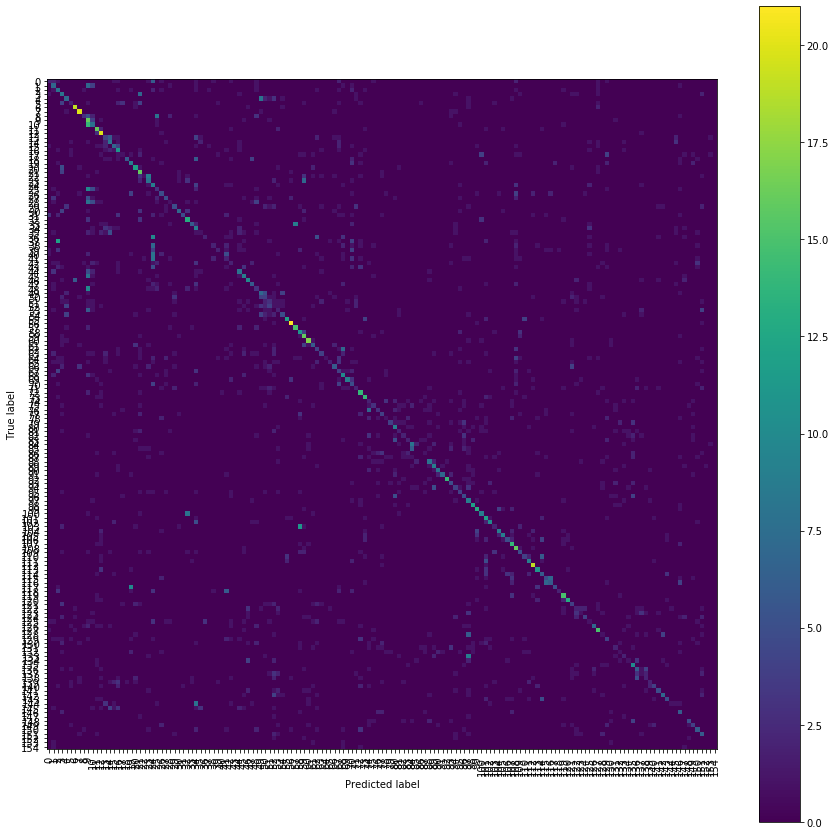

In [21]:
fig = plt.figure(figsize=(15, 15))
cm = confusion_matrix(valset.get_labels(), outputs)
ax = fig.add_subplot(111)
cm_display = ConfusionMatrixDisplay(cm,
                                    display_labels=np.arange(155)).plot(ax=ax,
                                                                       xticks_rotation="vertical",include_values = False)